# Import Modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import joblib
import pickle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Load Data (input)

In [2]:
model_data = pd.read_csv('../data/processed/model_data_bef_engineering.csv')

In [3]:
model_data.head()

,description,laf50_per_hour,result_hour,result_dayofweek,result_month,Temperature,LC_HUMIDITY,LC_RAININ,LC_WINDSPEED,break,class_human,class_music,class_transport,class_unsupported,class_wind
0,MP 01: Naamsestraat 35 Maxim,51.1,13,7,7,5.93613,43.121951,0.0,1.09,1,0.0,0.0,4.0,1.0,0.0
1,MP 02: Naamsestraat 57 Xior,54.6,13,7,7,5.93613,43.121951,0.0,1.09,1,NaN,NaN,NaN,NaN,NaN
2,MP 03: Naamsestraat 62 Taste,56.6,13,7,7,5.93613,43.121951,0.0,1.09,1,NaN,NaN,NaN,NaN,NaN
3,MP 05: Calvariekapel KU Leuven,55.3,13,7,7,5.93613,43.121951,0.0,1.09,1,0.0,0.0,0.0,1.0,0.0
4,MP 06: Parkstraat 2 La Filosovia,55.3,13,7,7,5.93613,43.121951,0.0,1.09,1,NaN,NaN,NaN,NaN,NaN


# Feature Engineering (function)

In [4]:
# Define a custom function to assign the time category based on the hour
def assign_day_category(hour):
    if 7 <= hour <= 18:
        return 'day'
    elif 19 <= hour <= 22:
        return 'evening'
    else:
        return 'night'

# Define a custom function to assign the time category based on the hour
def assign_week_category(day):
    if 1 <= day <= 5:
        return 'weekday'
    else:
        return 'weekend'
    
def group_time(model_data):
    
    """add day_category, week_category, season to input dataframe"""
    
    # Apply the function to create the new 'day_category' column based on the 'result_hour' column
    model_data['day_category'] = model_data['result_hour'].apply(assign_day_category)

    # Apply the function to create the new 'week_category' column based on the 'result_dayofweek' column
    model_data['week_category'] = model_data['result_dayofweek'].apply(assign_week_category)

    # create new column 'season' from 'result_month'
    model_data['season'] = model_data['result_month'].apply(lambda x: (x%12 + 3)//3)
    model_data['season'].replace({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}, inplace=True)
    
    # drop 'result_dayofweek','result_hour','result_month'
    drop_cols = ['result_dayofweek','result_hour','result_month']
    model_data.drop(columns = drop_cols, inplace = True)
    return model_data

In [5]:
# Deployment Step1
model_data = group_time(model_data)

In [6]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50320 entries, 0 to 50319
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   description        50320 non-null  object 
 1   laf50_per_hour     50320 non-null  float64
 2   Temperature        50320 non-null  float64
 3   LC_HUMIDITY        50320 non-null  float64
 4   LC_RAININ          50320 non-null  float64
 5   LC_WINDSPEED       50320 non-null  float64
 6   break              50320 non-null  int64  
 7   class_human        21724 non-null  float64
 8   class_music        21724 non-null  float64
 9   class_transport    21724 non-null  float64
 10  class_unsupported  21724 non-null  float64
 11  class_wind         21724 non-null  float64
 12  day_category       50320 non-null  object 
 13  week_category      50320 non-null  object 
 14  season             50320 non-null  object 
dtypes: float64(10), int64(1), object(4)
memory usage: 5.8+ MB


# Onehot Encoding

In [7]:
# Onehot encoding categorical columns
ohe_cols = ['description',
           'day_category','week_category','season',]
encoder = OneHotEncoder()
encoder.fit(model_data[ohe_cols])

encoded_data = encoder.transform(model_data[ohe_cols]).toarray()# convert the sparse matrix to array
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(ohe_cols))
df_encoded = pd.concat([model_data, encoded_df], axis=1)

# drop the already encoded original columns
df_encoded.drop(columns=ohe_cols,inplace=True)
df_encoded.head()

,laf50_per_hour,Temperature,LC_HUMIDITY,LC_RAININ,LC_WINDSPEED,break,class_human,class_music,class_transport,class_unsupported,...,description_MP08bis - Vrijthof,day_category_day,day_category_evening,day_category_night,week_category_weekday,week_category_weekend,season_Autumn,season_Spring,season_Summer,season_Winter
0,51.1,5.93613,43.121951,0.0,1.09,1,0.0,0.0,4.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,54.6,5.93613,43.121951,0.0,1.09,1,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,56.6,5.93613,43.121951,0.0,1.09,1,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,55.3,5.93613,43.121951,0.0,1.09,1,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,55.3,5.93613,43.121951,0.0,1.09,1,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Save Encoder for Deployment

In [8]:
# Write encoder to pickle file
with open('encoder.pkl', 'wb') as file:
    encoder = pickle.dump(encoder,file)

# Onehot Encoding - For Deployment reference (pickle+function)

In [9]:
def onehot_encode(model_data):
    
    # Read encoder from pickle file
    with open('encoder.pkl', 'rb') as file:
        loaded_encoder = pickle.load(file)

    ohe_cols = ['description',
               'day_category','week_category','season',]

    loaded_encoder.transform(model_data[ohe_cols]).toarray()
    encoded_df = pd.DataFrame(encoded_data, columns=loaded_encoder.get_feature_names_out(ohe_cols))
    df_encoded = pd.concat([model_data, encoded_df], axis=1)

    # drop the already encoded original columns
    df_encoded.drop(columns=ohe_cols,inplace=True)
    
    return df_encoded

# Model without noise events

In [10]:
df = df_encoded.copy()

In [11]:
# drop noise events related columns
noise_cols = [c for c in df.columns if 'class' in c or 'event_count' in c]
df_model = df.drop(noise_cols,axis=1)

# Create features X and target y
X = df_model.drop('laf50_per_hour',axis=1)
y = df_model['laf50_per_hour']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# initialize model
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(random_state=42)]

# Loop training and predict
for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f'Model Performance: {model.__class__.__name__}, Mean Squared Error: {mse}, R-squared: {r2}')

Model Performance: LinearRegression, Mean Squared Error: 21.82903366648558, R-squared: 0.5143471595475555
Model Performance: DecisionTreeRegressor, Mean Squared Error: 17.91819571409645, R-squared: 0.6013555717908808
Model Performance: RandomForestRegressor, Mean Squared Error: 10.48305176614712, R-squared: 0.7667728244582884


# Re-train Best Model and Save as Joblib

In [12]:
model_final = RandomForestRegressor(random_state=42)
model_final.fit(X,y)

RandomForestRegressor(random_state=42)

In [13]:
joblib.dump(model_final, 'RandomForestRegressor_woEvents.joblib')

['RandomForestRegressor_woEvents.joblib']

# Model Interpretation

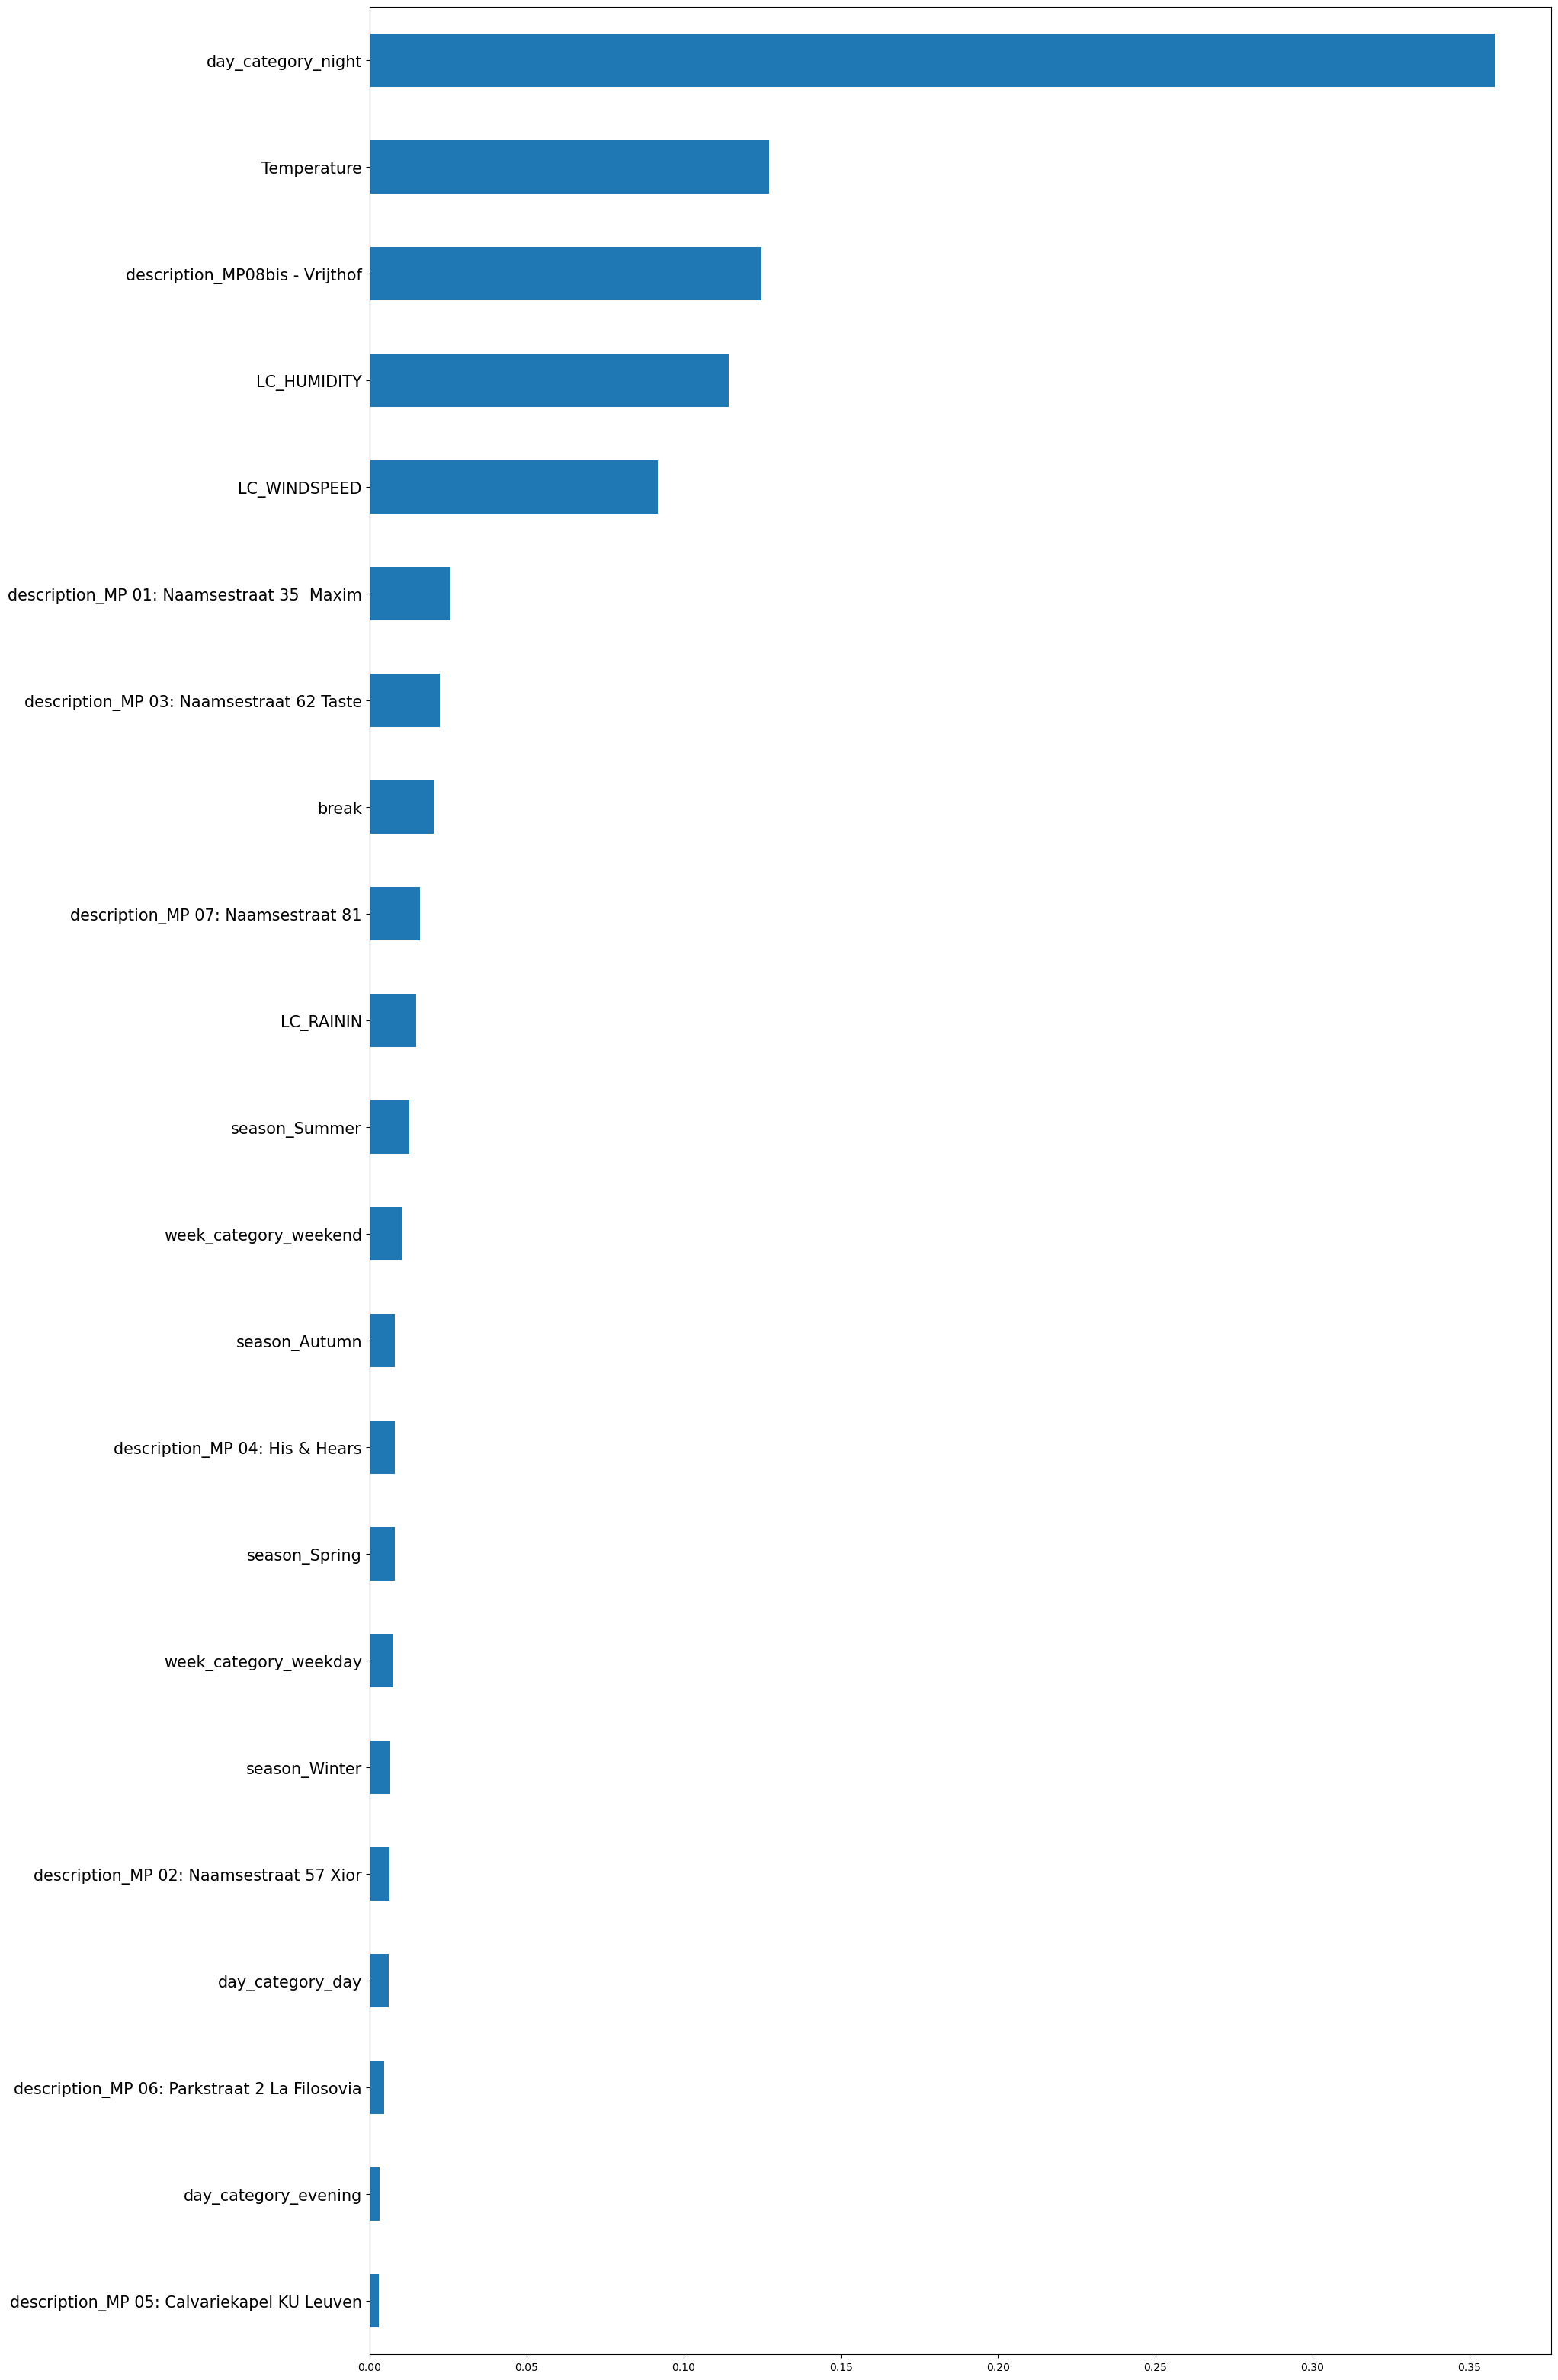

In [14]:
feature_importance = model_final.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))
feature_importance_s = pd.Series(feature_importance_dict)


fig,ax=plt.subplots(figsize=(20,40))
feature_importance_s.sort_values().plot(kind='barh',ax=ax)
ax.tick_params(axis='y', labelsize=15) 